In [26]:
#defining the classes Package, Bin and Student

class Package:
    def __init__(self, id, bin, location_in_bin, size, student):
        self.id = id
        self.size = size
        self.student = student  #student object
        self.letter = student.lastname_letter
        self.bin = bin
        self.location_in_bin = location_in_bin
        self.days_on_shelf = 0
        
    def getID(self):
        return self.id

    def getSize(self):
        return self.size
    
    def getLetter(self):
        return self.letter
    
    def getBin(self):
        return self.bin

    def getStudent(self):
        return self.student

    def getLocation(self):
        return self.location_in_bin

    def getDaysOnShelf(self):
        return self.days_on_shelf;

    def addDay(self):
        self.days_on_shelf = self.days_on_shelf+1

    # going to be used to modify Package when something is removed from its bin
    def setLocation(self, value):
        self.location_in_bin = value
    
    def __str__(self):
        return f"packageID: {self.id} {self.letter} | size = {self.size} | bin = {self.bin}, position {self.location_in_bin}"

    
class Bin:
    def __init__(self,label):
        self.label = label
        self.packages = []
    
    def addPackage(self,package):
        self.packages.append(package)
    
    def removePackage(self,package):
        self.packages.remove(package)

    def getLabel(self):
        return self.label
    
    def getPackages(self):
        return self.packages

    def getNumPackages(self):
        return len(self.packages)

    def __str__(self):
        return f"binID: {self.label}"

class Student: 
    def __init__(self,id,lastname_letter):
        self.id = id
        self.lastname_letter = lastname_letter.upper()

    def getID(self):
        return self.id

    def getLetter(self):
        return self.lastname_letter
        
    def __str__(self):
        return f"studentID: {self.id} | {self.lastname_letter}"

In [27]:
import pandas as pd
import numpy as np
import random as random

In [28]:
df = pd.read_csv('lastnames.csv')
df['Percentage'] = df['Percentage']*0.01
total_probability = df['Percentage'].sum()
df ["Probability"] = df['Percentage']/total_probability
lastname_distribution = df[['Letter','Probability']]
lastname_distribution.head()

,Letter,Probability
0,M,0.096154
1,S,0.094151
2,B,0.085136
3,C,0.077123
4,H,0.071114


In [29]:
def select_lastname_based_on_distribution(df):
    rand_val = random.random()
    cumulative_prob = 0
    for index, row in df.iterrows():
        cumulative_prob += row['Probability']
        if rand_val <= cumulative_prob:
            return row['Letter']

## better sim

In [30]:
pickup_dist = pd.read_csv('pickup_dist.csv')
arrival_counts_edited = pd.read_csv('arrival_counts_edited.csv')

In [31]:
# def select_pickup_based_on_distribution(df):
#     rand_val = random.random()
#     cumulative_prob = 0
#     for index, row in df.iterrows():
#         cumulative_prob += row['count']
#         if rand_val <= cumulative_prob:
#             return row['days_until_pickup']

In [32]:
def runLastNameSimulation2(packagesize_dist, lastname_dist, num_bins, arrival_counts_edited, pickup_dist, days):
    # for now, packagesize_dist is not implemented.

    #setup bins
    all_bins = [] #to store all the bins of this simulation
    #splits the alphabet into bins
    alpha_bin_names = np.array_split(list('ABCDEFGHIJKLMNOPQRSTUVWXYZ'), num_bins)
    #creates bins based on alphabet
    for name in alpha_bin_names:
       all_bins.append(Bin(str(name)))
    
    all_packages = [] #to store all the packages of this simulation
    all_students = [] #to store all the students of this simulation
    counter_packages = 0 # for packageID purposes
    counter_students = 0 #for studentID purposes

    #VARIBLES WE WANT TO TRACK IN THE SIMULATION WILL GO IN THIS:
    df = pd.DataFrame(columns=['day', 'studentID', 'packageID', 'rackTime', 'findTime', 'totalTime', 'days_to_pickup'])
    df_total_packages = pd.DataFrame(columns = ['day', 'num_packages', 'packages_expired'])

    for d in range(days):
        # print("day ", d)
        num_packages=  arrival_counts_edited.loc[d]['count']
        for i in range(num_packages):
            #randomly get the lastnameletter from the distribution 
            letter = select_lastname_based_on_distribution(lastname_dist)

            #make the student 
            all_students.append(Student(counter_students, letter))
            counter_students= counter_students + 1 #increase counter, so that the next student has a unique id 


            #determine which bin it goes in
            for j in range(num_bins):
                if letter in alpha_bin_names[j]:
                    bin_to_go_in = j #this returns the bin's index number in the all_bins list 
    
            #finally, make the package object
            package = (Package(counter_packages, bin_to_go_in, all_bins[bin_to_go_in].getNumPackages(), 'small', all_students[i]))
            all_packages.append(package)
            counter_packages= counter_packages + 1 #increase counter, so that the next package has a unique id 
            
            #update the bin so it knows it has a new package
            all_bins[bin_to_go_in].addPackage(package)

        #print where the packages were assigned to!
        # for p in all_packages:
        #     print(p)

        # for s in all_students:
        #     print(s)
                
        # --------------------------------------------------------------------------
        #BEGIN THE SIMULATION
        
        # there is some probability that a student comes to pick up their package today 
        
        # GEOMETRIC VERSION 
        # packages_picked_up_today = []
        # for package in all_packages:
        #     randomvar = random.random()
        #     if (randomvar <= ((1-geo_prob)**(package.getDaysOnShelf()-1))*geo_prob):
        #         packages_picked_up_today.append(package)

        # DISTRIBUTION VERSION
        packages_picked_up_today = []
        for package in all_packages:
            randomvar = random.random()
            prob_of_pickup = pickup_dist.loc[package.getDaysOnShelf()]['count']
            if (randomvar <= prob_of_pickup):
                packages_picked_up_today.append(package)

        #shuffle the packages being picked up today 
        random.shuffle(packages_picked_up_today)
            
        #now process the packages in this order
        for p in packages_picked_up_today:

            df.loc[len(df.index)] = [d, p.getStudent().getID(), p.getID(), p.getBin()+1, p.getLocation()+1, 
                                             p.getBin()+p.getLocation()+2, p.getDaysOnShelf()]
            
            #remove the package from the bin and adjust location in bin info
            all_bins[p.getBin()].removePackage(p)
            all_packages.remove(p)


            #adjust bin info for packages still in that bin, ONLY IF the package has a higher location_in_bin value than the removed package.
            for package in all_bins[p.getBin()].getPackages():
                if p.getLocation()<package.getLocation():
                        package.setLocation(package.getLocation()-1)

            #also remove the student -- by not doing this, all_students is now a list of just all students, not those with packages
            # print(p, p.getStudent())
            # all_students.remove(p.getStudent())
                

        #at the end of the day, increase the days_on_shelf counter for all leftover packages
        thrown_out_counter = 0;
        for p in all_packages: 
            p.addDay()
            #if the package has been there for over 1 week, remove it from the simulation
            if(p.getDaysOnShelf()>7):
                thrown_out_counter = thrown_out_counter+1
                all_bins[p.getBin()].removePackage(p)
                all_packages.remove(p)
                for package in all_bins[p.getBin()].getPackages():
                    if p.getLocation()<package.getLocation():
                            package.setLocation(package.getLocation()-1)


        #after we process everything for the day, save how many packages there are at the end of the day
        # df_total_packages .loc= pd.Dataframe(columns = ['day', 'num_packages'])
        df_total_packages.loc[len(df_total_packages.index)] = [d, len(all_packages), thrown_out_counter]


        # print(df)
        # print(df_total_packages)
    return df, df_total_packages



In [33]:
num_days = 90
package_df, day_df = runLastNameSimulation2('test', lastname_distribution, 26, arrival_counts_edited, pickup_dist, num_days)

In [34]:
print(package_df[['rackTime', 'findTime', 'totalTime', 'days_to_pickup']].mean())
print("avg number of packages at end of day:", day_df['num_packages'].mean())
print("total number of packages thrown out within the ", num_days, "simulation: ",  day_df['packages_expired'].sum())
print("avg number of packages thrown out within the ", num_days, "simulation: ",  day_df['packages_expired'].mean())

rackTime           11.259393
findTime          119.031551
totalTime         130.290943
days_to_pickup      0.764418
dtype: float64
avg number of packages at end of day: 1786.0
total number of packages thrown out within the  90 simulation:  15398
avg number of packages thrown out within the  90 simulation:  171.0888888888889


<Axes: xlabel='day'>

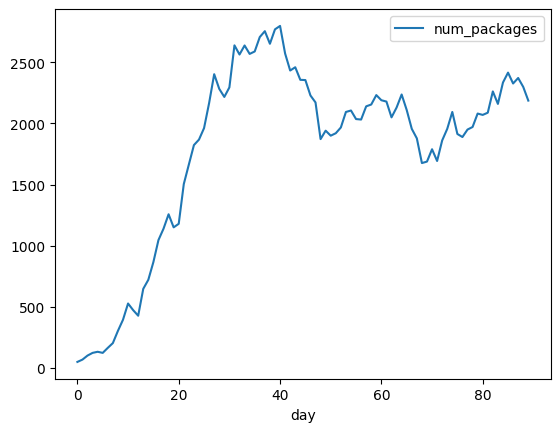

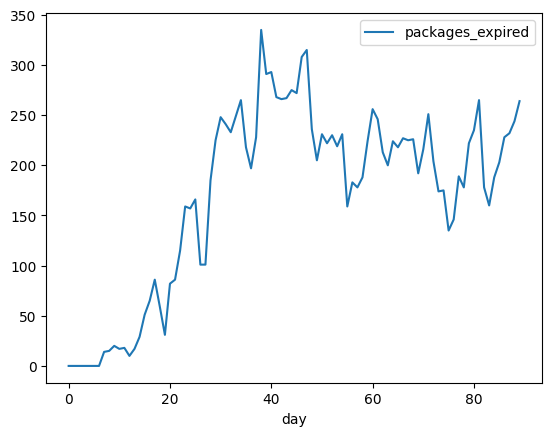

In [35]:
day_df.plot.line("day","num_packages")
day_df.plot.line("day","packages_expired")

In [36]:
def runHashSim(packagesize_dist, lastname_dist, num_bins, arrival_counts_edited, pickup_dist, days):
    # for now, packagesize_dist is not implemented.

    #setup bins
    all_bins = [] #to store all the bins of this simulation
    for i in range(num_bins):
        all_bins.append(Bin(str(i)))
    
    all_packages = [] #to store all the packages of this simulation
    all_students = [] #to store all the students of this simulation
    counter_packages = 0 # for packageID purposes
    counter_students = 0 #for studentID purposes

    #VARIBLES WE WANT TO TRACK IN THE SIMULATION WILL GO IN THIS:
    df = pd.DataFrame(columns=['day', 'studentID', 'packageID', 'rackTime', 'findTime', 'totalTime', 'days_to_pickup'])
    df_total_packages = pd.DataFrame(columns = ['day', 'num_packages', 'packages_expired'])

    for d in range(days):
        # print("day ", d)
        num_packages=  arrival_counts_edited.loc[d]['count']
        for i in range(num_packages):
            #randomly get the lastnameletter from the distribution 
            letter = select_lastname_based_on_distribution(lastname_dist)

            #make the student 
            all_students.append(Student(counter_students, letter))
            counter_students= counter_students + 1 #increase counter, so that the next student has a unique id 


            #determine which bin it goes in
            bin_to_go_in = counter_packages%num_bins
            initial_bin_to_go_in = bin_to_go_in
            while(len(all_bins[bin_to_go_in].getPackages()) > 300):
                 bin_to_go_in = (bin_to_go_in+1)%num_bins
                 if bin_to_go_in == initial_bin_to_go_in:
                      raise(Exception("NOOOOOOO"))
    
            #finally, make the package object
            package = (Package(counter_packages, bin_to_go_in, all_bins[bin_to_go_in].getNumPackages(), 'small', all_students[i]))
            all_packages.append(package)
            counter_packages= counter_packages + 1 #increase counter, so that the next package has a unique id 
            
            #update the bin so it knows it has a new package
            all_bins[bin_to_go_in].addPackage(package)

        #print where the packages were assigned to!
        # for p in all_packages:
        #     print(p)

        # for s in all_students:
        #     print(s)
                
        # --------------------------------------------------------------------------
        #BEGIN THE SIMULATION
        
        # there is some probability that a student comes to pick up their package today 
        
        # GEOMETRIC VERSION 
        # packages_picked_up_today = []
        # for package in all_packages:
        #     randomvar = random.random()
        #     if (randomvar <= ((1-geo_prob)**(package.getDaysOnShelf()-1))*geo_prob):
        #         packages_picked_up_today.append(package)

        # DISTRIBUTION VERSION
        packages_picked_up_today = []
        for package in all_packages:
            randomvar = random.random()
            prob_of_pickup = pickup_dist.loc[package.getDaysOnShelf()]['count']
            if (randomvar <= prob_of_pickup):
                packages_picked_up_today.append(package)

        #shuffle the packages being picked up today 
        random.shuffle(packages_picked_up_today)
            
        #now process the packages in this order
        for p in packages_picked_up_today:

            df.loc[len(df.index)] = [d, p.getStudent().getID(), p.getID(), p.getBin()+1, p.getLocation()+1, 
                                             p.getBin()+p.getLocation()+2, p.getDaysOnShelf()]
            
            #remove the package from the bin and adjust location in bin info
            all_bins[p.getBin()].removePackage(p)
            all_packages.remove(p)


            #adjust bin info for packages still in that bin, ONLY IF the package has a higher location_in_bin value than the removed package.
            for package in all_bins[p.getBin()].getPackages():
                if p.getLocation()<package.getLocation():
                        package.setLocation(package.getLocation()-1)

            #also remove the student -- by not doing this, all_students is now a list of just all students, not those with packages
            # print(p, p.getStudent())
            # all_students.remove(p.getStudent())
                

        #at the end of the day, increase the days_on_shelf counter for all leftover packages
        thrown_out_counter = 0;
        for p in all_packages: 
            p.addDay()
            #if the package has been there for over 1 week, remove it from the simulation
            if(p.getDaysOnShelf()>7):
                thrown_out_counter = thrown_out_counter+1
                all_bins[p.getBin()].removePackage(p)
                all_packages.remove(p)
                for package in all_bins[p.getBin()].getPackages():
                    if p.getLocation()<package.getLocation():
                            package.setLocation(package.getLocation()-1)


        #after we process everything for the day, save how many packages there are at the end of the day
        # df_total_packages .loc= pd.Dataframe(columns = ['day', 'num_packages'])
        df_total_packages.loc[len(df_total_packages.index)] = [d, len(all_packages), thrown_out_counter]


        # print(df)
        # print(df_total_packages)
    return df, df_total_packages



In [37]:
num_days = 90
package_df, day_df = runHashSim('test', lastname_distribution, 26, arrival_counts_edited, pickup_dist, num_days)

In [38]:
print(package_df[['rackTime', 'findTime', 'totalTime', 'days_to_pickup']].mean())
print("avg number of packages at end of day:", day_df['num_packages'].mean())
print("total number of packages thrown out within the ", num_days, "simulation: ",  day_df['packages_expired'].sum())
print("avg number of packages thrown out within the ", num_days, "simulation: ",  day_df['packages_expired'].mean())

rackTime          13.493851
findTime          75.225148
totalTime         88.718999
days_to_pickup     0.756938
dtype: float64
avg number of packages at end of day: 1771.3444444444444
total number of packages thrown out within the  90 simulation:  15302
avg number of packages thrown out within the  90 simulation:  170.0222222222222


<Axes: xlabel='day'>

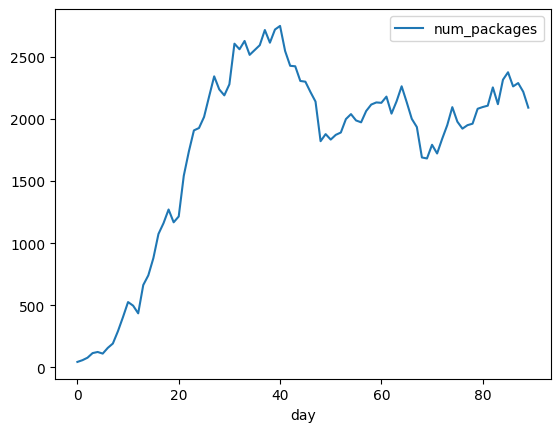

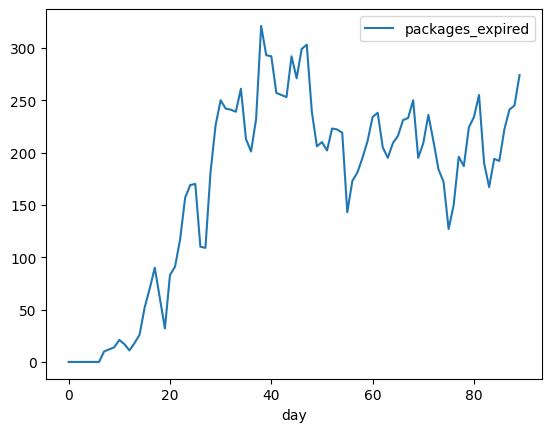

In [39]:
day_df.plot.line("day","num_packages")
day_df.plot.line("day","packages_expired")
